In [1]:
import firedrake
import hydropack
from hydropack.constants import *
from hydropack.cr_tools import *
from hydropack.models import glads

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
Lx, Ly = 60e3,20e3
nx,ny = 48, 32
mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)

In [3]:
Q = firedrake.FunctionSpace(mesh,"CG", 1)
V = firedrake.VectorFunctionSpace(mesh, "CG", 1)
CR = firedrake.FunctionSpace(mesh, "CR",1)

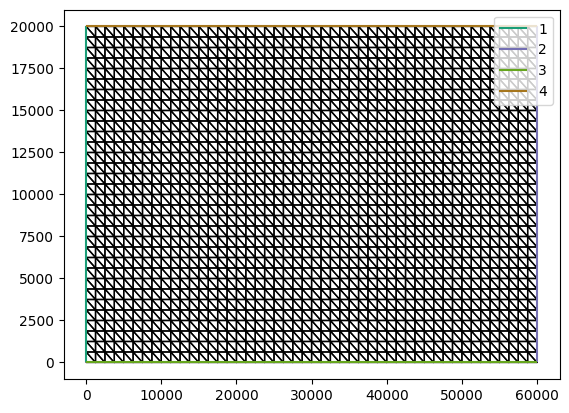

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
firedrake.triplot(mesh, axes=axes)
axes.legend();
#fig.savefig('mesh.png',dpi=200)

In [5]:
# Initial sheet height
h_init = firedrake.Function(Q);
h_init.interpolate(firedrake.Constant(0.03));

# Hydrology and ice flow
We know from observations of glacier surface velocity that the subglacial hydrology system can impact surface flow velocity. Icepack solves for velocity in meters per year where as these hydrology models typically represent fluxes in seconds.

In [6]:
x, y = firedrake.SpatialCoordinate(mesh);

u_b = firedrake.Function(Q);
u_b = firedrake.interpolate((50 + 250 * (60000 - x) / 60000) / 31536000, Q);

In [7]:
# Initial channel areas
S_init = firedrake.Function(CR)
S_init = firedrake.interpolate(firedrake.Constant(.00001),CR)
# Initial potential
phi_init = firedrake.Function(Q)
phi_init = firedrake.interpolate(firedrake.Constant(.0000001),Q)

# potential
phi = firedrake.Function(Q)
phi_prev = firedrake.Function(Q)

melt = firedrake.Function(Q)
melt = firedrake.interpolate(0.5 * (1.0 + (4.0 * (60000.0 - x) / 60000.0)) / 31536000.0, Q)

In [8]:
bed = firedrake.Function(Q)
bed = firedrake.interpolate(firedrake.Constant(0.0),Q)

h_max=1400.0
thickness = firedrake.Function(Q)
thickness = firedrake.interpolate(firedrake.sqrt((x + 50.0) * h_max**2 / Lx),Q)

p_i = firedrake.Function(Q)
p_i = firedrake.interpolate(ice_density * gravity * thickness, Q)

phi_m = firedrake.Function(Q)
phi_m = firedrake.interpolate(water_density * gravity * bed, Q)

phi_0 = firedrake.Function(Q)
phi_0 = firedrake.interpolate(p_i + phi_m, Q)

N = firedrake.Function(Q)
N = firedrake.interpolate(phi_0 - phi,Q)

In [9]:
bc = firedrake.DirichletBC(Q,phi_0,1)

# Overview of synthetic outlet glacier
Here we plot the thickness, and velocity of the glacier catchment that we aim to simulate with our subglacial hydrology model.

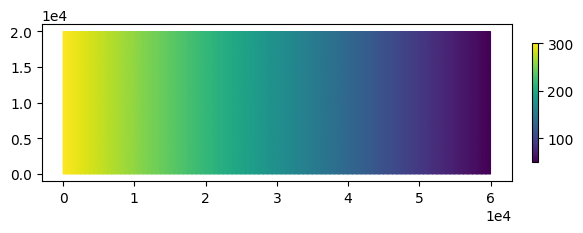

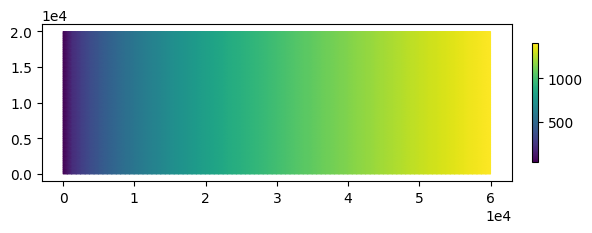

In [10]:
import icepack.plot

fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(firedrake.interpolate(u_b * 31536000.0,Q), axes=axes)
fig.colorbar(colors, ax=axes, fraction=0.012, pad=0.04);

fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(thickness, axes=axes)
fig.colorbar(colors, ax=axes, fraction=0.012, pad=0.04);

In [11]:
model_inputs = {}
model_inputs['mesh'] = mesh
model_inputs['h_init'] = h_init
model_inputs['S_init'] = S_init
model_inputs['thickness'] = thickness
model_inputs['bed'] = bed
model_inputs['u_b'] = u_b
model_inputs['m'] = melt
model_inputs['phi_prev'] = phi_init
model_inputs['phi_init'] = phi_init
model_inputs['d_bcs'] = [bc]
model_inputs['phi_m'] = phi_m
model_inputs['p_i'] = p_i
model_inputs['phi_0'] = phi_0
model_inputs['constants'] = pcs


# Create the Glads model
model = glads.Glads2DModel(model_inputs)

In [14]:
# Seconds per day
spd = pcs['spd']
# End time
T = 10.0 * spd
# Time step
dt = 60.0 * 30.0
# Irataion count
i = 0

while model.t < T:
    current_time = model.t / spd
    print("Current Time: " + str(current_time))
    model.step(dt)
    if i % 24 == 0:
        model.write_pvds()
  

Current Time: 0.0


ValueError: Discontinuous type SpatialCoordinate must be restricted.